## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Import Important Implementations

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
%matplotlib inline

## Helper Habit

In [2]:
def show_images(images, columns=2, cmap=None):
    rows = math.ceil(len(images)/columns)
    f, axarr = plt.subplots(rows, columns, figsize=(20, rows*4))
    for index, image in enumerate(images):
        x = index % columns
        y = int(index / columns)
        
        if len(axarr.shape) > 1:
            axarr[y, x].imshow(image, cmap=cmap)
        else:
            axarr[x].imshow(image, cmap=cmap)

## Compute Camera Calibration

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

In [4]:
def undistort(img):
    
    size = (img.shape[1], img.shape[0])
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size, None,None)
    
    return cv2.undistort(img, mtx, dist, None, mtx)

In [5]:
def warp(img, undo=False):
    
    img_size = (img.shape[1], img.shape[0])
    size = img.shape
    
    dst_offset = 300
    dst = np.float32([
        (size[1]/2-dst_offset, 0), 
        (size[1]/2+dst_offset, 0), 
        (size[1]/2+dst_offset, 720), 
        (size[1]/2-dst_offset, 720)
    ])
    
    src_top_offset = 45
    src_bottom_offset = 450
    src = np.float32([
        (int(size[1]/2-src_top_offset), 450), 
        (int(size[1]/2+src_top_offset), 450), 
        (int(size[1]/2+src_bottom_offset), 720),
        (int(size[1]/2-src_bottom_offset), 720)
    ])
    
    
    if not undo:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst,src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)    
    
    return warped, M

In [6]:
def binerize(img, s_thresh=(120, 255), sx_thresh=(20, 255), l_thresh=(50, 255), alt=False):
    #img = cv2.blur(img.copy(), (20,20))
    img = img.copy()
    
    # Convert to hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel xls
    #l_blur = cv2.blur(l_channel, (10, 0))
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=15)
    
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold l channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(s_binary), sxbinary, np.zeros_like(l_binary),)) * 255
    
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    
    return binary, color_binary

In [7]:
def reduce_noise(gray):
    
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (20,20))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))

    mask = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)

    gray = gray * mask
    return gray

In [8]:
def crop(gray):
    
    size = gray.shape
    
    offset = 350 # A little bigger than dst_offset from warp()
    
    vertices = np.array([
        [
            (0,0),
            (size[1],0),
            (size[1]/2+offset, size[0]),
            (size[1]/2-offset, size[0]), 
        ]
    ],dtype=np.int32)

    mask = np.zeros_like(gray)
    ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(gray, mask)
    
    return masked_image


In [9]:
def find_lines(binary):
    histogram = np.sum(binary[(binary.shape[0]//2):,:], axis=0)
    midpoint = histogram.shape[0]//2
    
    # Assumes you are in the center of a lane
    left_peak = np.argmax(histogram[:midpoint])
    right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    window_height = binary.shape[0]//nwindows
    
    nonzeroy, nonzerox = binary.nonzero()
    
    leftx_current = left_peak
    rightx_current = right_peak
    
    margin = 100
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = binary.shape[0] - (window+1)*window_height
        win_y_high = binary.shape[0] - window*window_height

        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Find pixels in rectangle
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

def find_lines_from(binary, left_fit, right_fit):
    nonzeroy, nonzerox = img.nonzero()

    margin = 100

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Etract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

## Corrected Copy

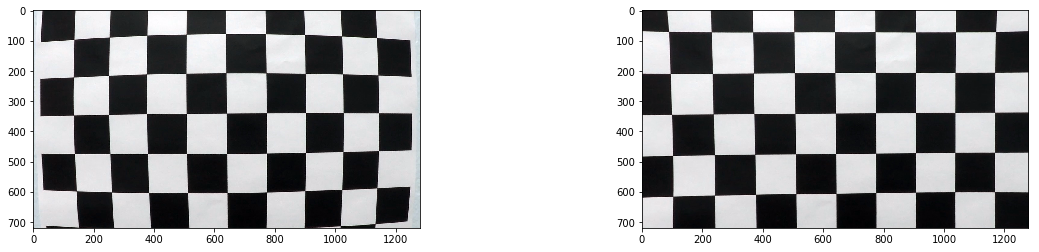

In [10]:
img = cv2.imread('../camera_cal/calibration1.jpg')

#f, axarr = plt.subplots(1, 2, figsize=(20, 10))

show_images([img, undistort(img)])

## Road Images

In [11]:
paths = glob.glob('../test_images/*.jpg')

images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in paths]
images = images

### Undistort

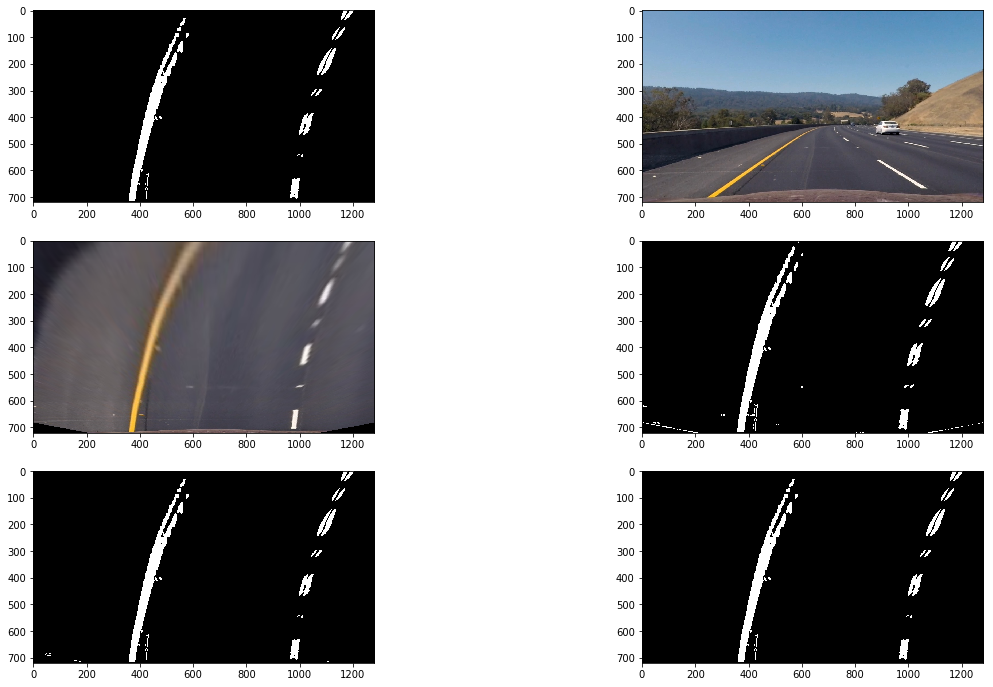

In [12]:
img_original = images[4]
img_undistort = undistort(img_original)
img_warp = warp(img_undistort)[0]
img_binerize = binerize(img_warp)[0]
img_denoised = reduce_noise(img_binerize)
img_cropped = crop(img_denoised)

img = img_cropped

show_images([img, img_undistort, img_warp, img_binerize, img_denoised, img_cropped], cmap='gray')

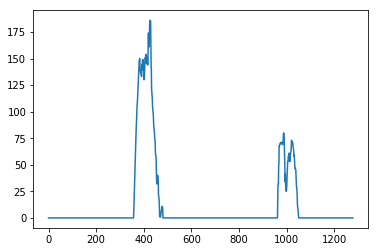

In [13]:
histogram = np.sum(img[(img.shape[0]//2):,:], axis=0)
plt.plot(histogram)

In [14]:
histogram = np.sum(img[(img.shape[0]//2):,:], axis=0)

out_img = np.dstack((img, img, img))*255

midpoint = histogram.shape[0]//2

# Assumes you are in the center of a lane
left_peak = np.argmax(histogram[:midpoint])
right_peak = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 9
window_height = img.shape[0]//nwindows

nonzeroy, nonzerox = img.nonzero()

leftx_current = left_peak
rightx_current = right_peak

margin = 100
minpix = 50

left_lane_inds = []
right_lane_inds = []

for window in range(nwindows):
    win_y_low = img.shape[0] - (window+1)*window_height
    win_y_high = img.shape[0] - window*window_height
    
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw rectangle for visualization
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
    
    # Find pixels in rectangle
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

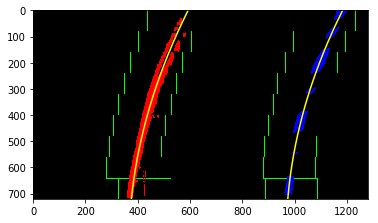

In [15]:
# Generate x and y values for plotting
ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [16]:
nonzeroy, nonzerox = img.nonzero()

margin = 100

left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                  (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                   (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

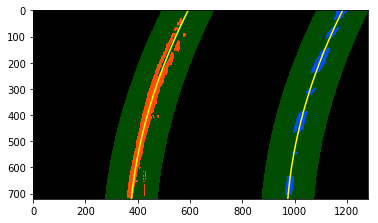

In [17]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((img, img, img))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)